In [2]:
import numpy as np

bbox_worldcord = [1, 25, 0, 0, 0, 0] # [x,y,z, roll, pitch, yaw]
ego_vehicle_worldcord = [3,29,0,0,0,177] # [x,y,z, roll, pitch, yaw]

def bbox_to_ego(bbox_worldcord:list =[0,0,0,0,0,0], ego_vehicle_worldcord:list =[0,0,0,0,0,0]):
    # bbox_worldcord and ego_vehicle_worldcord are in format [x,y,z, roll, pitch, yaw] (degrees)
    
    def rotation_matrix(roll, pitch, yaw):
        roll = roll * np.pi / 180
        pitch = pitch * np.pi / 180
        yaw = yaw * np.pi / 180
        R_x = np.array([[1, 0, 0],
                        [0, np.cos(roll), -np.sin(roll)],
                        [0, np.sin(roll), np.cos(roll)]])
        R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                        [0, 1, 0],
                        [-np.sin(pitch), 0, np.cos(pitch)]])
        R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                        [np.sin(yaw), np.cos(yaw), 0],
                        [0, 0, 1]])
        R = R_z @ R_y @ R_x
        return R
    # Extract positions and orientations
    bbox_pos = np.array(bbox_worldcord[0:3])
    bbox_rot = bbox_worldcord[3:6]
    ego_pos = np.array(ego_vehicle_worldcord[0:3])
    ego_rot = ego_vehicle_worldcord[3:6]

    # Compute rotation matrices
    R_ego = rotation_matrix(ego_rot[0], ego_rot[1], ego_rot[2])
    R_ego_inv = R_ego.T  # Inverse of rotation matrix is its transpose for rotation matrices
    R_bbox = rotation_matrix(bbox_rot[0], bbox_rot[1], bbox_rot[2])

    bbox_ego_coords = R_ego_inv @ (bbox_pos - ego_pos)
    bbox_ego_rotation = R_ego_inv @ R_bbox
    # Convert rotation matrix back to Euler angles
    sy = np.sqrt(bbox_ego_rotation[0,0] ** 2 + bbox_ego_rotation[1,0] ** 2)
    singular = sy < 1e-6
    if not singular:
        x = np.arctan2(bbox_ego_rotation[2,1], bbox_ego_rotation[2,2])
        y = np.arctan2(-bbox_ego_rotation[2,0], sy)
        z = np.arctan2(bbox_ego_rotation[1,0], bbox_ego_rotation[0,0])
    else:
        x = np.arctan2(-bbox_ego_rotation[1,2], bbox_ego_rotation[1,1])
        y = np.arctan2(-bbox_ego_rotation[2,0], sy)
        z = 0   
    bbox_ego_rotation = np.array([x, y, z])
    
    bbox_ego_rotation = bbox_ego_rotation * 180 / np.pi

    return bbox_ego_coords, bbox_ego_rotation

newcord, newrot = bbox_to_ego(bbox_worldcord,ego_vehicle_worldcord)
print(newcord, newrot)

[1.78791524 4.09919005 0.        ] [   0.   -0. -177.]


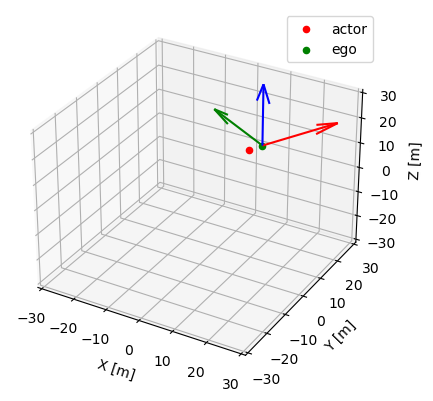

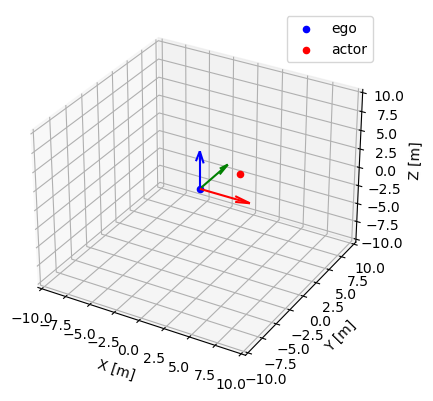

In [3]:
#plot the worldcord and ego coord
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bbox_worldcord[0], bbox_worldcord[1], bbox_worldcord[2], c='r', label=f'actor')
ax.scatter(ego_vehicle_worldcord[0], ego_vehicle_worldcord[1], ego_vehicle_worldcord[2], c='g', label='ego')
bbox_ego_coords, bbox_ego_rotation = bbox_to_ego(bbox_worldcord, ego_vehicle_worldcord)
#put rotation arrows to the ego car showing the roll, pitch, yaw of the ego vehicle in worldcord
def euler_to_matrix(roll, pitch, yaw):
    # Roll (x), pitch (y), yaw (z), angles given in radians
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    Ry = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    # Apply in ZYX: yaw, pitch, roll
    return Rz @ Ry @ Rx

R = euler_to_matrix(ego_vehicle_worldcord[3], ego_vehicle_worldcord[4], ego_vehicle_worldcord[5])

# Local basis vectors
axes = np.eye(3)  # unit x, y, z

# Draw 3 arrows for the rotated local axes from the point
for i, color in enumerate(['r', 'g', 'b']):  # x, y, z axes
    dir_vec = R @ axes[:,i]
    ax.quiver(*ego_vehicle_worldcord[0:3], *dir_vec, length=25, color=color, normalize=True)





#ax.scatter(bbox_worldcord[0], bbox_worldcord[1],-30, c='black', label='xbb')
#ax.scatter(-30, bbox_worldcord[1],bbox_worldcord[2], c='black', label='ybb')
#ax.scatter(bbox_worldcord[0], 30,bbox_worldcord[2], c='black', label='zbb')


#ax.scatter(bbox_ego_coords[0], bbox_ego_coords[1], bbox_ego_coords[2], c='b', label='bbox ego cord')
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0, 0, 0, c='b', label='ego')
ax.quiver(0, 0, 0, 1, 0, 0, length=5, color='r', normalize=True)
ax.quiver(0, 0, 0, 0, 1, 0, length=5, color='g', normalize=True)
ax.quiver(0, 0, 0, 0, 0, 1, length=5, color='b', normalize=True)
ax.scatter(bbox_ego_coords[0], bbox_ego_coords[1], bbox_ego_coords[2], c='r', label=f'actor')
#ax.scatter(bbox_ego_coords[0], bbox_ego_coords[1],-30, c='black', label='xbb')
#ax.scatter(-30, bbox_ego_coords[1],bbox_ego_coords[2], c='black', label='ybb')
#ax.scatter(bbox_ego_coords[0], 30,bbox_ego_coords[2], c='black', label='zbb')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.legend()
plt.show()

In [ ]:
new_coords, new_rotation = bbox_to_ego(bbox_worldcord, ego_vehicle_worldcord)
print("New Coordinates in Ego Frame:", new_coords)
print("New Rotation in Ego Frame (roll, pitch, yaw):", new_rotation)

In [ ]:
import h5py
import numpy as np
to_type ={
  0 : "Unlabeled",
  1 : "Roads",
  2 : "SideWalks",
  3 : "Buildings",
  4 : "Wall",
  5 : "Fence",
  6 : "Pole",
  7 : "TrafficLight",
  8 : "TrafficSign",
  9 : "Vegetation",
  10 : "Terrain",
  11 : "Sky",
  12 : "Pedestrian",
  13 : "Rider",
  14 : "Car",
  15 : "Truck",
  16 : "Bus",
  17 : "Train",
  18 : "Motorcycle",
  19 : "Bicycle",
  20 : "Static",
  21 : "Dynamic",
  22 : "Other",
  23 : "Water",
  24 : "RoadLine",
  25 : "Ground",
  26 : "Bridge",
  27 : "RailTrack",
  28 : "GuardRail", 
}
with h5py.File('/home/npopkov/repos/IR2025/data/20251128_1241_10v_150w_3sp/db/lidar_data.h5', 'r') as f, h5py.File('/home/npopkov/repos/IR2025/data/20251128_1241_10v_150w_3sp/bbox.h5', 'r') as f_bbox:
    print(f['_carla_ego_vehicle_lidar_front'].keys())
    print(f_bbox.keys())
    print(f_bbox['actor_id_type_map'][:])
    print(len(f['_carla_ego_vehicle_lidar_front'].keys()))
    print(len(list(f_bbox.keys())[1:]))
    actors = list(f_bbox['frame_000006']['actors'])
    print(actors)
    ids = []
    uuids = []
    print(f_bbox["actor_id_type_map"][:])
    


In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
with h5py.File('/home/npopkov/repos/IR2025/data/251119_eight_lidar_10s/bbox.h5', 'r') as f_bbox, h5py.File('/home/npopkov/repos/IR2025/data/251119_eight_lidar_10s/bbox_ego.h5', 'r') as f_bbox_ego:
    frame = 'frame_000066'
    #print(f_bbox[frame]['actors'][0:2,1:4])
    print(f_bbox_ego[frame]['actors'][:,0:3])
    #print(np.unique(list(f_bbox[frame]['actors'][:,1])))
    uniques = np.unique(list(f_bbox_ego[frame]['actors'][:,2]))
    print(np.max(uniques), np.min(uniques),f"difference: {np.max(uniques)-np.min(uniques)}")


In [ ]:
{1, 2, 5, 14, 20}
Roads
SideWalks
Fence
Car
Static